# 5. Классификация текстов при помощи сетей прямого распространения

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г.

In [61]:
import re
import string
import typing as t
from pathlib import Path
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from nltk.corpus import stopwords, wordnet
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, random_split, DataLoader

In [62]:
torch.set_warn_always(True)
sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)
DATA_DIR = Path("data/")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE.upper()} device")

Using CPU device


In [63]:
def on_cuda(device: str) -> bool:
    return device == "cuda"

In [64]:
def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        train_dataloader: DataLoader,
        epochs: int,
        verbose: int = 100,
        test_dataloader: DataLoader = None,
        device: str = "cpu",
) -> t.List[float]:
    train_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)
        train_loss = train_loop(
            train_dataloader,
            model,
            loss_fn,
            optimizer,
            verbose=verbose,
            device=device,
        )
        train_losses.append(train_loss.item())
        if test_dataloader:
            test_loop(test_dataloader, model, loss_fn, device=device)
        torch.cuda.empty_cache()
    return train_losses


In [65]:
def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = 100,
        device: str = "cpu",
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss
        if batch % verbose == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return avg_loss / num_batches

In [66]:
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = "cpu",
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, correct = 0, 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        avg_loss += loss_fn(pred, y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

        del x, y, pred
        torch.cuda.empty_cache()

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy

In [67]:
def plot_losses(losses: t.Any) -> None:
    plt.plot(torch.arange(len(losses)), losses)

## 1. Представление и предобработка текстовых данных 

1.1 Операции по предобработке:
* токенизация
* стемминг / лемматизация
* удаление стоп-слов
* удаление пунктуации
* приведение к нижнему регистру
* любые другие операции над текстом

In [68]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

Реализовать функцию `preprocess_text(text: str) -> str`, которая:
* приводит строку к нижнему регистру
* заменяет все символы, кроме a-z, A-Z и знаков .,!? на пробел


In [69]:
def get_pos(word: str) -> str:
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [70]:
def preprocess_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z.!?]", repl=" ", string=text, flags=re.MULTILINE)
    punctuation = set(string.punctuation)
    stop_words = set(stopwords.words("english"))
    lemmatizer = nltk.WordNetLemmatizer()
    sentences = []
    for sent in nltk.sent_tokenize(text):
        words = []
        for word in nltk.word_tokenize(sent):
            # отбросить некоторые слова до лемматизации - чуть-чуть сэкономит время
            if word not in stop_words and word not in punctuation:
                lemma = lemmatizer.lemmatize(word, pos=get_pos(word))
                if lemma not in stop_words:
                    words.append(lemma)
        sentences.append(" ".join(words))
    text = ". ".join(sentences)
    text = re.sub(r"[!?]", repl=".", string=text, flags=re.MULTILINE)
    return text
preprocess_text(text)

'select preference run install command. stable represent currently test support version pytorch. note libtorch available c'

1.2 Представление текстовых данных при помощи бинарного кодирования


Представить первое предложение из `text` в виде тензора `sentence_t`: `sentence_t[i] == 1`, если __слово__ с индексом `i` присутствует в предложении.

In [71]:
text_ = preprocess_text(text)
alphabet = list(set(nltk.word_tokenize(text_)) - {"."})
word_to_idx = {word: i for i, word in enumerate(alphabet)}
sentence = nltk.sent_tokenize(text_)[0]
sentence = sentence[:-1] if sentence[-1] == '.' else sentence
sentence_t = torch.zeros(len(alphabet))
word_indices = [word_to_idx[w] for w in nltk.word_tokenize(sentence)]
sentence_t[word_indices] = 1
sentence_t

tensor([0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

## 2. Классификация фамилий по национальности

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`.

In [72]:
surnames = pd.read_csv("surnames.csv")
surnames.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


2.2 Закодировать национальности числами, начиная с 0.

In [73]:
labeler = LabelEncoder()
surnames["target"] = labeler.fit_transform(surnames["nationality"])
print(f"classes: {len(labeler.classes_)}")
surnames.head()

classes: 18


,surname,nationality,target
0,Woodford,English,4
1,Coté,French,5
2,Kore,English,4
3,Koury,Arabic,0
4,Lebzak,Russian,14


2.4 Реализовать класс `Vocab` (токен = __символ__)

In [74]:
class Vocab:
    def __init__(self, data: t.Iterable[str]):
        self.idx_to_token = list({ch for w in data for ch in w.lower()})
        self.token_to_idx = {t: i for i, t in enumerate(self.idx_to_token)}
        self.vocab_len = len(self.idx_to_token)
vocab = Vocab(surnames["surname"])
vocab.vocab_len

55

2.5 Реализовать класс `SurnamesDataset`

In [75]:
class SurnamesDataset(Dataset):
    def __init__(self, data: t.List[str], targets: torch.Tensor, vocab: Vocab):
        self.data = data
        self.targets = targets
        self.vocab = vocab

    def vectorize(self, surname: str) -> torch.Tensor:
        vec = torch.zeros(self.vocab.vocab_len)
        indices = [self.vocab.token_to_idx[ch] for ch in surname.lower()]
        vec[indices] = 1
        return vec

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.vectorize(self.data[idx]), self.targets[idx]
surnames_dataset = SurnamesDataset(
    data=surnames["surname"].tolist(),
    targets=torch.tensor(surnames["target"], dtype=torch.long),
    vocab=vocab,
)

2.3 Разбить датасет на обучающую и тестовую выборку

In [76]:
train_size = round(0.8 * len(surnames_dataset))
test_size = len(surnames_dataset) - train_size
train_dataset, test_dataset = random_split(surnames_dataset, lengths=(train_size, test_size))
len(train_dataset), len(test_dataset)

(8784, 2196)

2.6. Обучить классификатор.

In [77]:
class SurnamesClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super(SurnamesClassifier, self).__init__()
        self.seq = nn.Sequential(  # простой классификатор
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, out_features),
            # Интересно, почему в лекциях иногда используют CrossEntropyLoss, а иногда SoftMax + NLLLoss?
            # Они же эквивалентны: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
            nn.LogSoftmax(dim=1),
        )

    def forward(self, inputs):
        return self.seq(inputs)

In [78]:
torch.manual_seed(0)
net = SurnamesClassifier(vocab.vocab_len, vocab.vocab_len).to(DEVICE)
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512)

In [79]:
train_losses = common_train(
    epochs=20,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=300,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 4.041303  [    0/ 8784]
loss: 1.495364  [ 2400/ 8784]
loss: 2.547904  [ 4800/ 8784]
loss: 0.755988  [ 7200/ 8784]
Test Error: 
 Accuracy: 0.508197, Avg loss: 1.516162 

Epoch 2
--------------------------------
loss: 1.551797  [    0/ 8784]
loss: 1.229257  [ 2400/ 8784]
loss: 0.837363  [ 4800/ 8784]
loss: 1.605946  [ 7200/ 8784]
Test Error: 
 Accuracy: 0.551457, Avg loss: 1.420111 

Epoch 3
--------------------------------
loss: 2.207312  [    0/ 8784]
loss: 1.377480  [ 2400/ 8784]
loss: 1.709790  [ 4800/ 8784]
loss: 1.480855  [ 7200/ 8784]
Test Error: 
 Accuracy: 0.582878, Avg loss: 1.370939 

Epoch 4
--------------------------------
loss: 0.859607  [    0/ 8784]
loss: 0.891102  [ 2400/ 8784]
loss: 1.447222  [ 4800/ 8784]
loss: 2.121900  [ 7200/ 8784]
Test Error: 
 Accuracy: 0.590164, Avg loss: 1.315199 

Epoch 5
--------------------------------
loss: 1.068374  [    0/ 8784]
loss: 0.754189  [ 2400/ 8784]
loss: 1.762213  [ 4800/ 8784]
loss:

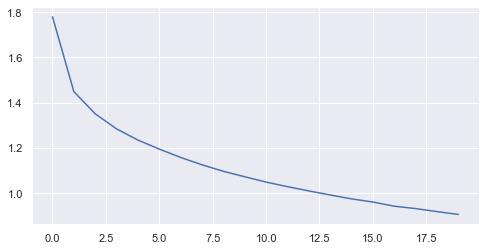

In [80]:
plot_losses(train_losses)

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [81]:
test_loop(dataloader=test_dataloader, model=net, loss_fn=loss_fn, device=DEVICE);

Test Error: 
 Accuracy: 0.631148, Avg loss: 1.202913 



In [82]:
def inference(
        surname: str,
        target: str,
        model: nn.Module,
        dataset: SurnamesDataset,
        labeler: LabelEncoder,
        k: int = 3,
        device: str = "cpu",
):
    x = dataset.vectorize(surname)
    x = x.to(device)

    pred = model(x.unsqueeze(0))
    pred_proba, pred_label_indices = F.softmax(pred, 1).topk(k, dim=1)
    pred_labels = labeler.inverse_transform(pred_label_indices.squeeze().cpu())

    predicts = ", ".join(
        [f"{label} ({prob:.2f})" for (label, prob) in zip(pred_labels, pred_proba.squeeze())]
    )
    print(f"Surname : {surname}")
    print(f"True    : {target}")
    print(f"Predicts: {predicts}\n")

In [83]:
students = [
    "Alexandrova",
    "Baranov",
    "Brusova",
    "Volkova",
    "Kovalev",
    "Kostyuchenko",
    "Kuzin",
    "Likhachev",
    "Telitsyn",
    "Ustimova",
    "Khamikoeva",
]
for surname in students:
    inference(
        surname=surname,
        target="Russian",
        model=net,
        dataset=surnames_dataset,
        labeler=labeler,
        device=DEVICE,
    )

Surname : Alexandrova
True    : Russian
Predicts: English (0.88), French (0.06), Dutch (0.03)

Surname : Baranov
True    : Russian
Predicts: Russian (0.48), Italian (0.30), Czech (0.07)

Surname : Brusova
True    : Russian
Predicts: Russian (0.56), Czech (0.24), Greek (0.11)

Surname : Volkova
True    : Russian
Predicts: Russian (0.64), Czech (0.32), English (0.01)

Surname : Kovalev
True    : Russian
Predicts: Russian (0.74), Dutch (0.11), English (0.08)

Surname : Kostyuchenko
True    : Russian
Predicts: Russian (0.91), English (0.06), Dutch (0.02)

Surname : Kuzin
True    : Russian
Predicts: Russian (0.62), Japanese (0.22), Czech (0.06)

Surname : Likhachev
True    : Russian
Predicts: Russian (0.88), Czech (0.07), English (0.05)

Surname : Telitsyn
True    : Russian
Predicts: English (0.73), Russian (0.22), Dutch (0.01)

Surname : Ustimova
True    : Russian
Predicts: Russian (0.83), Greek (0.09), Japanese (0.05)

Surname : Khamikoeva
True    : Russian
Predicts: Russian (1.00), Czech

**Вывод:** полносвязные слои удовлетворительно справляются с символами и словами.

## 3. Классификация обзоров ресторанов

Датасет: https://disk.yandex.ru/d/nY1o70JtAuYa8g


3.1 Считать файл `yelp/raw_train.csv`. Оставить от исходного датасета 10% строчек.

In [84]:
reviews = pd.read_csv("raw_train.csv", header=None)
print(len(reviews))
reviews.head()

560000


,0,1
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [85]:
reviews = reviews.sample(frac=0.1, ignore_index=True, random_state=0)
print(len(reviews))
reviews.head()

56000


,0,1
0,2,"Call me crazy, but I really enjoyed this place..."
1,1,"HORRIBLE, HORRIBLE, HORRIBLE ONLINE CUSTOMER S..."
2,2,The staff were extremely helpful in answering ...
3,2,The steak tartare is fantastic! I'd come back...
4,2,Everything I could want for $3.


3.2 Воспользоваться функцией `preprocess_text` из 1.1 для обработки текста отзыва. Закодировать рейтинг числами, начиная с 0.

In [86]:
labeler = LabelEncoder()
reviews[0] = labeler.fit_transform(reviews[0])
reviews[1] = reviews[1].apply(lambda t: preprocess_text(t).replace(".", ""))
print(f"classes: {len(labeler.classes_)}")
reviews.head()

classes: 2


,0,1
0,1,call crazy really enjoy place get ton food dec...
1,0,horrible horrible horrible online customer ser...
2,1,staff extremely helpful answer question take t...
3,1,steak tartare fantastic come back vega dine gr...
4,1,everything could want


3.4 Реализовать класс `Vocab` (токен = слово).

In [87]:
class Vocab:
    def __init__(self, data: t.Iterable[str]):
        self.idx_to_token = list({w for text in data for w in nltk.word_tokenize(text)} - {"."})
        self.token_to_idx = {t: i for i, t in enumerate(self.idx_to_token)}
        self.vocab_len = len(self.idx_to_token)
vocab = Vocab(reviews[1])
vocab.vocab_len

60218

3.5 Реализовать класс `ReviewDataset`.

In [88]:
class ReviewDataset(Dataset):
    def __init__(self, data: t.List[str], targets: torch.Tensor, vocab: Vocab):
        self.data = data
        self.targets = targets
        self.vocab = vocab

    def vectorize(self, review: str):
        vec = torch.zeros(self.vocab.vocab_len)
        indices = [self.vocab.token_to_idx[w] for w in nltk.word_tokenize(review)]
        vec[indices] = 1
        return vec

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.vectorize(self.data[idx]), self.targets[idx]
reviews_dataset = ReviewDataset(
    data=reviews[1].tolist(),
    targets=torch.tensor(reviews[0], dtype=torch.long),
    vocab=vocab,
)

3.3 Разбить датасет на обучающую и тестовую выборку.

In [89]:
train_size = round(0.8 * len(reviews_dataset))
test_size = len(reviews_dataset) - train_size
train_dataset, test_dataset = random_split(reviews_dataset, lengths=(train_size, test_size))
len(train_dataset), len(test_dataset)

(44800, 11200)

3.6 Обучить классификатор.

In [90]:
class ReviewsClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super(ReviewsClassifier, self).__init__()
        self.seq = nn.Sequential(  # простой классификатор и тут справится с задачей?
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, out_features),
            # Интересно, почему в лекциях иногда используют CrossEntropyLoss, а иногда SoftMax + NLLLoss?
            # Они же эквивалентны: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
            nn.LogSoftmax(dim=1),
        )

    def forward(self, inputs):
        return self.seq(inputs)

In [91]:
torch.manual_seed(0)
net = ReviewsClassifier(vocab.vocab_len, vocab.vocab_len).to(DEVICE)
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024)

In [92]:
train_losses = common_train(
    epochs=4,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=200,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 10.992883  [    0/44800]
loss: 0.455714  [12800/44800]
loss: 0.404619  [25600/44800]
loss: 0.420688  [38400/44800]
Test Error: 
 Accuracy: 0.911964, Avg loss: 0.255935 

Epoch 2
--------------------------------
loss: 0.257176  [    0/44800]
loss: 0.093364  [12800/44800]
loss: 0.179933  [25600/44800]
loss: 0.104061  [38400/44800]
Test Error: 
 Accuracy: 0.916696, Avg loss: 0.222681 

Epoch 3
--------------------------------
loss: 0.163183  [    0/44800]
loss: 0.171181  [12800/44800]
loss: 0.123891  [25600/44800]
loss: 0.272693  [38400/44800]
Test Error: 
 Accuracy: 0.913482, Avg loss: 0.226486 

Epoch 4
--------------------------------
loss: 0.102601  [    0/44800]
loss: 0.068869  [12800/44800]
loss: 0.129531  [25600/44800]
loss: 0.123264  [38400/44800]
Test Error: 
 Accuracy: 0.912232, Avg loss: 0.234696 



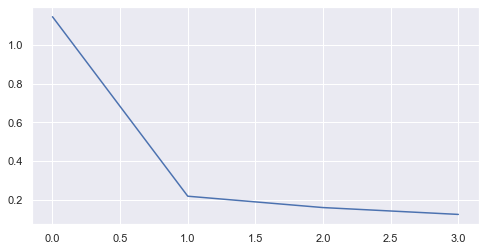

In [93]:
plot_losses(train_losses)

3.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва).

In [94]:
test_loop(dataloader=test_dataloader, model=net, loss_fn=loss_fn, device=DEVICE);

Test Error: 
 Accuracy: 0.912232, Avg loss: 0.234696 



In [95]:
def inference(
        review: str,
        target: int,
        model: nn.Module,
        dataset: ReviewDataset,
        labeler: LabelEncoder,
        device: str = "cpu",
):
    x = dataset.vectorize(review)
    x = x.to(device)

    pred = model(x.unsqueeze(0))
    pred_proba, pred_label_idx = F.softmax(pred, 1).max(dim=1)
    pred_label = labeler.inverse_transform([pred_label_idx.cpu()])

    print(f"Review : {review}")
    print(f"True   : {target}")
    print(f"Predict: {pred_label.item()} ({pred_proba.item():.2f})\n")

reviews = [
    ("Everything is very bad. This is the worst place I haven't bothered to visit.", 1),
    ("A wonderful place. I liked everything.", 2),
]
for review, target in reviews:
    inference(
        review=preprocess_text(review).replace(".", ""),
        target=target,
        model=net,
        dataset=reviews_dataset,
        labeler=labeler,
        device=DEVICE,
    )

Review : everything bad bad place bother visit
True   : 1
Predict: 1 (0.84)

Review : wonderful place like everything
True   : 2
Predict: 2 (0.93)



c:\users\ace\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1023: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y = np.asarray(y)
